In [1]:
import numpy as np

In [2]:
import PIL
from PIL import Image
import random

In [3]:
import matplotlib
import math
import matplotlib.pyplot as plt

In [4]:
import os
import random
import copy
from os import listdir
from collections import defaultdict

In [5]:
def load_data(data_dir="./aligned/"):
    """ Load all PNG images stored in your data directory into a list of NumPy
        arrays.

    Args:
    data_dir: The relative directory path to the CompCar image directory.
    Returns:
        images: A dictionary with keys as car types and a list containing images associated with each key.
        cnt: A dictionary that stores the # of images in each car type
    """
    images = defaultdict(list)

    # Get the list of car type directory:
    for e in listdir(data_dir):
        # excluding any non-directory files
        if not os.path.isdir(os.path.join(data_dir, e)):
            continue
        # Get the list of image file names
        all_files = listdir(os.path.join(data_dir, e))

        for file in all_files:
            # Load only image files as PIL images and convert to NumPy arrays
            if '.jpg' in file:
                img = Image.open(os.path.join(data_dir, e, file))
                images[e].append(np.array(img))

    print("Car types: {} \n".format(list(images.keys())))

    cnt = defaultdict(int)
    for e in images.keys():
        print("{}: {} # of images".format(e, len(images[e])))
        cnt[e] = len(images[e])
    return images, cnt


In [6]:
# this function takes in all the img from all set and return a list of sets of mutually exclusive images and its labels.
def k_fold(imgs, k):
    res = []
    for _ in range(k):
        res.append(defaultdict(list))
    for key in imgs.keys():
        random.shuffle(imgs[key], lambda: 0.6)
        for i, entry in enumerate(imgs[key]):
            res[i%k][key].append(entry)
    return res

In [7]:
def PCA(X, n_components):

    """Args:
        X: has shape Mxd where M is the number of images and d is the dimension of each image
        n_components: The number of components you want to project your image onto. 
    
    Returns:
        projected: projected data of shape M x n_components
        mean_image: mean of all images
        top_sqrt_eigen_values: singular values
        top_eigen_vectors: eigenvectors 
    """
    mean_image = np.average(X, axis = 0)

    msd = X - mean_image # M x d

    smart_cov_matrix = np.matmul(msd, msd.T)
    eigen_values, smart_eigen_vectors = np.linalg.eig(smart_cov_matrix)

    idx = eigen_values.argsort()[::-1]   
    eigen_values = eigen_values[idx]
    smart_eigen_vectors = smart_eigen_vectors[:,idx]

    eigen_vectors = (np.matmul(msd.T, smart_eigen_vectors)).T # M x d

    row_norm = np.sum(np.abs(eigen_vectors)**2,axis=-1)**(1./2) # M

    normalized_eigen_vectors = eigen_vectors/(row_norm.reshape(-1, 1)) # M x d

    top_eigen_vectors = normalized_eigen_vectors[:n_components].T
    top_sqrt_eigen_values = np.sqrt(eigen_values[:n_components])

    projected = np.matmul(msd, top_eigen_vectors)/top_sqrt_eigen_values

    return projected, mean_image, top_sqrt_eigen_values, top_eigen_vectors

In [8]:
def PCA_test(X, mean_image, top_sqrt_eigen_values, top_eigen_vectors):
    msd = X - mean_image # M x d
    projected = np.matmul(msd, top_eigen_vectors)/top_sqrt_eigen_values
    return projected

In [9]:
def trainingLoader(train, test, validation, targets):
    TrainingX = [] 
    ValidationX = []
    TestingX = []
    
    Trainingy = []
    Validationy = []
    Testingy = []
    
    for classType, keyWord in enumerate(targets):
        for i in range(len(train[keyWord])):
            TrainingX.append(train[keyWord][i].reshape((-1)))
            Trainingy.append(classType)
        for i in range(len(validation[keyWord])):
            ValidationX.append(validation[keyWord][i].reshape((-1)))
            Validationy.append(classType)
        for i in range(len(test[keyWord])):
            TestingX.append(test[keyWord][i].reshape((-1)))
            Testingy.append(classType)
    
    TrainingX = np.array(TrainingX)
    ValidationX = np.array(ValidationX)
    TestingX = np.array(TestingX)
    
    #TrainingX = np.append(np.array(TrainingX) , np.ones((len(TrainingX), 1)), 1)
    #ValidationX = np.append(np.array(ValidationX), np.ones((len(ValidationX), 1)), 1)
    #TestingX = np.append(np.array(TestingX), np.ones((len(TestingX), 1)), 1)
    
    Trainingy = np.array(Trainingy).reshape(1, -1).T
    Validationy = np.array(Validationy).reshape(1, -1).T
    Testingy = np.array(Testingy).reshape(1, -1).T
    
    return TrainingX, ValidationX, TestingX, Trainingy, Validationy, Testingy

In [10]:
def addBias(TrainingX, ValidationX, TestingX):
    TrainingX = np.append(np.array(TrainingX) , np.ones((len(TrainingX), 1)), 1)
    ValidationX = np.append(np.array(ValidationX), np.ones((len(ValidationX), 1)), 1)
    TestingX = np.append(np.array(TestingX), np.ones((len(TestingX), 1)), 1)
    return TrainingX, ValidationX, TestingX

In [11]:
class Logistic_regression:
    
    def __init__(self, dimension, lr):
        self.lr = lr
        self.delta = 10**(-7)
        self.w = np.zeros(dimension)
        
    def sigmoid(self, X):
        return 1.0 / (1.0 + np.exp(-X))
    
    def caculateGradient(self, X, yTrue):
        grad = X * (yTrue.reshape(-1) - self.sigmoid(X@self.w)).reshape((-1, 1))
        return np.sum(grad, axis=0)
    
    def updateWeight(self, X, yTrue):
        self.w += self.lr * self.caculateGradient(X, yTrue)
        
    def predict(self, X):
        vfunc = np.vectorize(lambda x: 1 if x > 0.5 else 0)
        return vfunc(self.sigmoid(X@self.w.T))
    
    def score(self, X, yTrue):
        yCalculated = self.predict(X)
        correct = 0
        for i in range(len(X)):
            if yCalculated[i] == yTrue[i]:
                correct += 1
        return correct / len(yCalculated)
    
    def logLikelihood(self, X, yTrue):
        expected = self.sigmoid(self.w @ X.T)
        
        Onemins = 1-  expected + self.delta
        expected += self.delta
        #print(expected.T, yTrue.T)
        LLs = yTrue*np.log(expected).reshape((-1,1)) + (1-yTrue)*np.log(Onemins).reshape((-1,1))
        return LLs.sum(axis=0)[0]
    
    def fit(self, X, y):
        log = []
        for _ in range(epoch):
            self.updateWeight(X, y)
            log.append(self.logLikelihood(X, y))
        return log
    
    def fit(self, X, y):
        self.updateWeight(X, y)
        return self.logLikelihood(X, y)
        
    
    def stochastic_fit(self, X, y, epoch):
        llog = []
        for _ in range(epoch):
            for x in range(len(X)):
                self.updateWeight(X[i], y[i])
                log.append(self.logLikelihood(X, y))
        return log

In [53]:
def Q5B(n_components, learningRate):
    img, cnt = load_data(data_dir="./resized/")
    folds = k_fold(img, 10)
    test, validation = folds[0], folds[1]
    train = defaultdict(list)
    for trainLoaderIter in range(2, 10):
        for key in folds[trainLoaderIter].keys():
            train[key].extend(folds[trainLoaderIter][key])
    TrainingX, ValidationX, TestX, Trainingy, Validationy, Testy = trainingLoader(train, test, validation, ["Minivan", "Convertible"])
    TrainingX, mean_image, top_sqrt_eigen_values, top_eigen_vectors = PCA(TrainingX, n_components)
    ValidationX = PCA_test(ValidationX, mean_image, top_sqrt_eigen_values, top_eigen_vectors)
    TestX = PCA_test(TestX, mean_image, top_sqrt_eigen_values, top_eigen_vectors)
    TrainingX, ValidationX, TestX = addBias(TrainingX, ValidationX, TestX)
    
    LR = Logistic_regression(TrainingX.shape[1], learningRate)
    llsTrain = []
    llsValidate = []
    accsTrain = []
    accsValidate = []
    prevAcc = 0
    for _ in range(300):
        llT = LR.fit(TrainingX, Trainingy)
        llsTrain.append(llT)
        llV = LR.logLikelihood(ValidationX, Validationy)
        llsValidate.append(llV)
        
        accT = LR.score(TrainingX, Trainingy)
        accsTrain.append(accT)
        accV = LR.score(ValidationX, Validationy)
        accsValidate.append(accV)
        #print(prevAcc)
        if prevAcc > accV:
            LR.w = prevWeights
            print("Stopped when the acc is get worse")
            break
        prevAcc = accV
        prevWeights = LR.w
    
    fig, axs = plt.subplots(2, 1, figsize=(4, 6), constrained_layout=True)
    axs[0].plot(list(range(len(llsTrain))),llsTrain, label='Train')
    axs[0].plot(list(range(len(llsValidate))),llsValidate, label='Validation')
    axs[0].set_title("Log likelihood vs Steps")
    axs[0].set_xlabel("Steps")
    axs[0].set_ylabel("Log likelihood")
    axs[0].legend(loc='best')

    axs[1].plot(list(range(len(accsTrain))),accsTrain, label='Train')
    axs[1].plot(list(range(len(accsValidate))),accsValidate, label='Validation')
    axs[1].set_xlabel("Steps")
    axs[1].set_title("Accurate rate vs Steps")
    axs[1].set_ylabel("Accurate rate")
    axs[1].legend(loc='best')
    plt.show()

    print("The acc rate in test set is : ", LR.score(TestX, Testy))

    fig, axs = plt.subplots(4, 1, figsize=(6, 9),constrained_layout=True)
    for i in range(4):
        imgArr = (top_eigen_vectors.T)[i].reshape(200, 300)
        imgArr += imgArr.min()
        imgArr *= 255.0/imgArr.max()
        axs[i].imshow(imgArr, cmap='gray')

Part B of Q5
Car types: ['Convertible', 'Minivan'] 

Convertible: 150 # of images
Minivan: 150 # of images


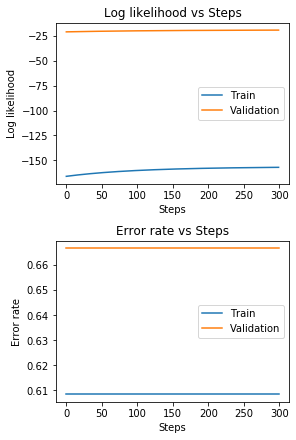

The acc rate in test set is :  0.7


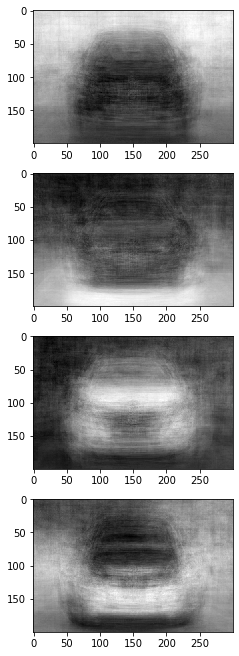

In [54]:
print("Part B of Q5")
Q5B(10, 0.02)

In [13]:
def Q5C(n_components, learningRate, k, printService):
    img, cnt = load_data(data_dir="./aligned/")
    folds = k_fold(img, k)
    llss = []
    testAcc = []
    accss = []
    globleBest = 0
    gobleBestWeight = np.zeros(n_components+1)
    for i in range(k):
        test, validation = folds[i], folds[(i+1)%k]
        train = defaultdict(list)
        #print((i+2)%k, (i+k)%k)
        for trainLoaderIter in range((i+2), (i+k)):
            #print(trainLoaderIter)
            trainLoaderIter = trainLoaderIter % k
            for key in folds[trainLoaderIter].keys():
                train[key].extend(folds[trainLoaderIter][key])
        #print(len(test), len(validation), train.keys())
        TrainingX, ValidationX, TestX, Trainingy, Validationy, Testy = trainingLoader(train, test, validation, ["Minivan", "Convertible"])
        TrainingX, mean_image, top_sqrt_eigen_values, top_eigen_vectors = PCA(TrainingX, n_components)
        #print(top_eigen_vectors.shape)
        ValidationX = PCA_test(ValidationX, mean_image, top_sqrt_eigen_values, top_eigen_vectors)
        TestX = PCA_test(TestX, mean_image, top_sqrt_eigen_values, top_eigen_vectors)
        TrainingX, ValidationX, TestX = addBias(TrainingX, ValidationX, TestX)
        #print(TrainingX.shape)
        LR = Logistic_regression(TrainingX.shape[1], learningRate)
        if printService == True and i == 1:
            fig, axs = plt.subplots(4, 1, figsize=(6, 9),constrained_layout=True)
            for i in range(4):
                imgArr = (top_eigen_vectors.T)[i].reshape(200, 300)
                imgArr += imgArr.min()
                imgArr *= 255.0/imgArr.max()
                axs[i].imshow(imgArr, cmap='gray')
            print("The eigen for aligned data")
        lls = []
        accs = []
        maxAcc = 0
        for _ in range(300):
            ll = LR.fit(TrainingX, Trainingy)
            lls.append(ll)
            acc = LR.score(ValidationX, Validationy)
            accs.append(acc)
            #print(prevAcc)
            if acc > maxAcc:
                prevWeights = LR.w
                maxAcc = acc
                if acc > globleBest:
                    gobleBest = acc
                    globleBestWeight = LR.w
        # LR now have the best weight in this data set.
        LR.w = prevWeights
        testAcc.append(LR.score(TestX, Testy))
        llss.append(lls)
        accss.append(accs)
        
    averageLLs = [0]*300
    averageAccs  = [0] * 300
    standardDivMean = []
    standadDiv = []
    standardDivIndex = []
    for i in range(300):
        avgll = 0
        avgacc = 0
        
        for j in range(k):
            avgll += llss[j][i]
            avgacc += accss[j][i]
            
        avgll /= k
        avgacc /= k
        averageLLs[i] = avgll
        averageAccs[i] = avgacc
        if i % 50 == 0:
            tmp = []
            for j in range(k):
                tmp.append(accss[j][i])
            standadDiv.append(np.std(tmp))
            standardDivMean.append(avgacc)
            standardDivIndex.append(i)
    #print(max(averageAccs))
    
        
        
    fig, axs = plt.subplots(3, 1, figsize=(4, 12), constrained_layout=True)
    axs[0].plot(list(range(len(averageLLs))),averageLLs, '-')
    axs[0].set_title("Log likelihood vs Steps (Training)")
    axs[0].set_xlabel("Steps")
    axs[0].set_ylabel("Log likelihood")
    #fig.suptitle('This is a somewhat long figure title', fontsize=16)

    axs[1].plot(list(range(len(averageAccs))),averageAccs, '-')
    axs[1].set_xlabel("Steps")
    axs[1].set_title("Acc rate vs Steps (Validation)")
    axs[1].set_ylabel("Acc rate")
    
    
    axs[2].bar(standardDivIndex, standardDivMean, yerr=standadDiv, width = 20, align='center', alpha=0.5, ecolor='black', capsize=10)
    axs[2].set_xlabel("Steps")
    axs[2].set_title("Acc rate vs Steps (Validation)")
    axs[2].set_ylabel("Acc rate")
    
    plt.show()
    print("The average test acc is : ", np.average(testAcc), " and the standard divation of these acc is ", np.std(testAcc))

This is part C i, ii, of Q5
Car types: ['Convertible', 'Pickup', 'Minivan', 'Sedan'] 

Convertible: 149 # of images
Pickup: 150 # of images
Minivan: 148 # of images
Sedan: 150 # of images
The eigen for aligned data


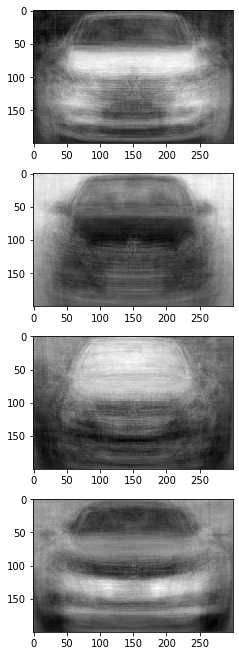

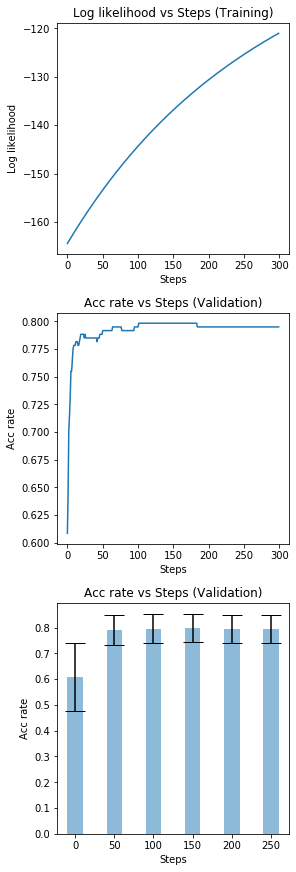

The average test acc is :  0.7750082101806239  and the standard divation of these acc is  0.06750753007269494


In [14]:
print("This is part C i, ii, of Q5")
Q5C(20, 0.008, 10, True)

Car types: ['Pickup', 'Sedan', 'Minivan', 'Convertible'] 

Pickup: 150 # of images
Sedan: 150 # of images
Minivan: 148 # of images
Convertible: 149 # of images


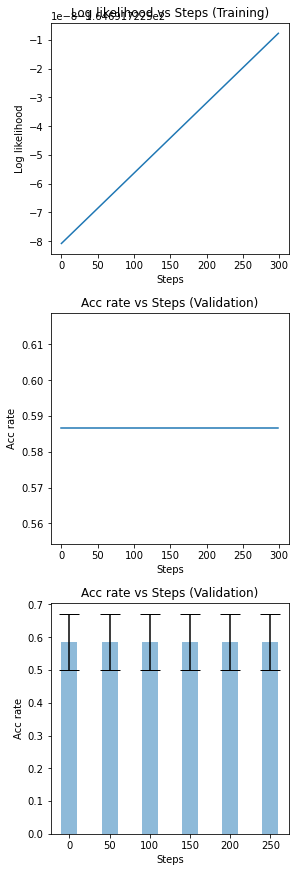

The average test acc is :  0.6228735632183908  and the standard divation of these acc is  0.11259728108509245


In [16]:
Q5C(20, 0.000000000008, 10, False)

Car types: ['Pickup', 'Sedan', 'Minivan', 'Convertible'] 

Pickup: 150 # of images
Sedan: 150 # of images
Minivan: 148 # of images
Convertible: 149 # of images


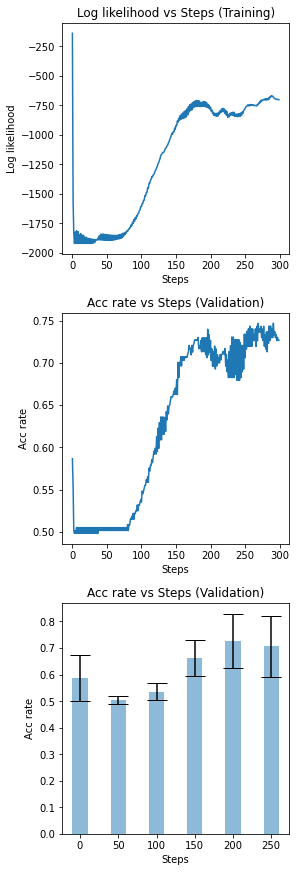

The average test acc is :  0.7460919540229884  and the standard divation of these acc is  0.09861834522841026


In [17]:
Q5C(20, 2, 10, False)

In [18]:
def Q5D(n_components, learningRate, k, printService):
    img, cnt = load_data(data_dir="./aligned/")
    folds = k_fold(img, k)
    llss = []
    testAcc = []
    accss = []
    globleBest = 0
    gobleBestWeight = np.zeros(n_components+1)
    for i in range(k):
        test, validation = folds[i], folds[(i+1)%k]
        train = defaultdict(list)
        #print((i+2)%k, (i+k)%k)
        for trainLoaderIter in range((i+2), (i+k)):
            #print(trainLoaderIter)
            trainLoaderIter = trainLoaderIter % k
            for key in folds[trainLoaderIter].keys():
                train[key].extend(folds[trainLoaderIter][key])
        #print(len(test), len(validation), train.keys())
        TrainingX, ValidationX, TestX, Trainingy, Validationy, Testy = trainingLoader(train, test, validation, ["Sedan", "Pickup"])
        TrainingX, mean_image, top_sqrt_eigen_values, top_eigen_vectors = PCA(TrainingX, n_components)
        #print(top_eigen_vectors.shape)
        ValidationX = PCA_test(ValidationX, mean_image, top_sqrt_eigen_values, top_eigen_vectors)
        TestX = PCA_test(TestX, mean_image, top_sqrt_eigen_values, top_eigen_vectors)
        TrainingX, ValidationX, TestX = addBias(TrainingX, ValidationX, TestX)
        #print(TrainingX.shape)
        LR = Logistic_regression(TrainingX.shape[1], learningRate)
        if printService == True and i == 1:
            fig, axs = plt.subplots(4, 1, figsize=(6, 9),constrained_layout=True)
            for i in range(4):
                imgArr = (top_eigen_vectors.T)[i].reshape(200, 300)
                imgArr += imgArr.min()
                imgArr *= 255.0/imgArr.max()
                axs[i].imshow(imgArr, cmap='gray')
            print("The eigen for aligned data")
        lls = []
        accs = []
        maxAcc = 0
        for _ in range(300):
            ll = LR.fit(TrainingX, Trainingy)
            lls.append(ll)
            acc = LR.score(ValidationX, Validationy)
            accs.append(acc)
            #print(prevAcc)
            if acc > maxAcc:
                prevWeights = LR.w
                maxAcc = acc
                if acc > globleBest:
                    gobleBest = acc
                    globleBestWeight = LR.w
        # LR now have the best weight in this data set.
        LR.w = prevWeights
        testAcc.append(LR.score(TestX, Testy))
        llss.append(lls)
        accss.append(accs)
        
    averageLLs = [0]*300
    averageAccs  = [0] * 300
    standardDivMean = []
    standadDiv = []
    standardDivIndex = []
    for i in range(300):
        avgll = 0
        avgacc = 0
        
        for j in range(k):
            avgll += llss[j][i]
            avgacc += accss[j][i]
            
        avgll /= k
        avgacc /= k
        averageLLs[i] = avgll
        averageAccs[i] = avgacc
        if i % 50 == 0:
            tmp = []
            for j in range(k):
                tmp.append(accss[j][i])
            standadDiv.append(np.std(tmp))
            standardDivMean.append(avgacc)
            standardDivIndex.append(i)
    #print(max(averageAccs))
    
        
        
    fig, axs = plt.subplots(3, 1, figsize=(4, 12), constrained_layout=True)
    axs[0].plot(list(range(len(averageLLs))),averageLLs, '-')
    axs[0].set_title("Log likelihood vs Steps (Training)")
    axs[0].set_xlabel("Steps")
    axs[0].set_ylabel("Log likelihood")
    #fig.suptitle('This is a somewhat long figure title', fontsize=16)

    axs[1].plot(list(range(len(averageAccs))),averageAccs, '-')
    axs[1].set_xlabel("Steps")
    axs[1].set_title("Acc rate vs Steps (Validation)")
    axs[1].set_ylabel("Acc rate")
    
    
    axs[2].bar(standardDivIndex, standardDivMean, yerr=standadDiv, width = 20, align='center', alpha=0.5, ecolor='black', capsize=10)
    axs[2].set_xlabel("Steps")
    axs[2].set_title("Acc rate vs Steps (Validation)")
    axs[2].set_ylabel("Acc rate")
    
    plt.show()
    print("The average test acc is : ", np.average(testAcc), " and the standard divation of these acc is ", np.std(testAcc))

Car types: ['Pickup', 'Sedan', 'Minivan', 'Convertible'] 

Pickup: 150 # of images
Sedan: 150 # of images
Minivan: 148 # of images
Convertible: 149 # of images
The eigen for aligned data


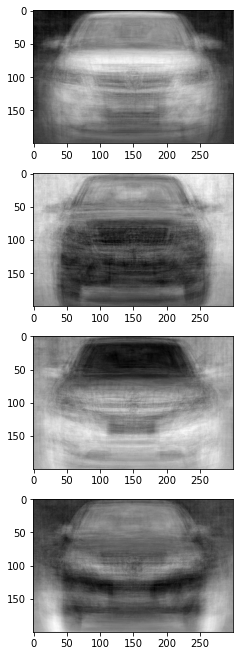

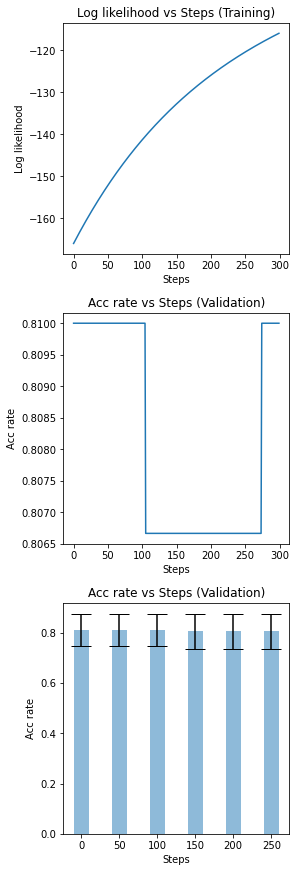

The average test acc is :  0.8033333333333333  and the standard divation of these acc is  0.07371114795831996


In [19]:
Q5D(20, 0.01, 10, True)

In [20]:
class Logistic_regression_softMax:
    
    # No need to change
    def __init__(self, dimension, lr):
        self.lr = lr
        self.delta = 10**(-7)
        self.w = np.zeros(dimension)
    
    # No need to change
    def sigmoid(self, X):
        return 1.0 / (1.0 + np.exp(-X))
    
    # New added, done
    def softmax(self, lable):
        return np.exp(lable) / np.sum(np.exp(lable), axis=0)
    
    # Done
    # no batch possible
    def caculateGradient(self, X, yTrue):
        grad = X * (yTrue.reshape(-1) - self.softmax(X@self.w)).reshape((-1, 1)) #--> 4 by 1
        #print(grad.shape)
        return grad.T
    
        #grad = X * (yTrue.reshape(-1) - self.sigmoid(X@self.w)).reshape((-1, 1))
        #return np.sum(grad, axis=0)
    
    # No need to change
    def updateWeight(self, X, yTrue):
        self.w += self.lr * self.caculateGradient(X, yTrue)
        
    def batch_fit(self, X, yTrue):
        grad = np.zeros(self.w.shape)
        for i in range(len(X)):
            grad += self.caculateGradient(X[i], yTrue[i])
        #grad /= len(X)
        self.w += self.lr * grad
   
    
    # no batch prediction
    def predict(self, X):
        res = np.zeros(self.w.shape[1])
        res[np.argmax(self.softmax(X@self.w))] = 1
        return res
    
    # Should be correct
    def score(self, X, yTrue):
        correct = 0
        for i in range(len(X)):
            ans = self.predict(X[i])
            if (ans==yTrue[i].reshape(-1)).all():
                correct += 1
        return correct / len(X)
    
    
    # Cost function, 
    def loss(self, X, yTrue):
        res = 0
        for i in range(len(X)):
            yTrue[i].reshape(-1)
            predicted = self.softmax(X[i]@self.w)
            res -= np.sum(yTrue[i] * np.log(predicted))
        return res
            

    
    def stochastic_fit(self, X, y):
        randomAccess = list(range(len(X)))
        random.shuffle(randomAccess)
        for i in randomAccess:
            self.updateWeight(X[i], y[i])
        #return 0

In [21]:
def trainingLoaderSoftmax(train, test, validation, targets):
    TrainingX = [] 
    ValidationX = []
    TestingX = []
    
    Trainingy = []
    Validationy = []
    Testingy = []
    
    for classType, keyWord in enumerate(targets):
        for i in range(len(train[keyWord])):
            TrainingX.append(train[keyWord][i].reshape((-1)))
            Trainingy.append(np.zeros(len(targets)))
            Trainingy[-1][classType] = 1
        for i in range(len(validation[keyWord])):
            ValidationX.append(validation[keyWord][i].reshape((-1)))
            Validationy.append(np.zeros(len(targets)))
            Validationy[-1][classType] = 1
        for i in range(len(test[keyWord])):
            TestingX.append(test[keyWord][i].reshape((-1)))
            Testingy.append(np.zeros(len(targets)))
            Testingy[-1][classType] = 1
    
    TrainingX = np.array(TrainingX)
    ValidationX = np.array(ValidationX)
    TestingX = np.array(TestingX)
    
    Trainingy = np.array(Trainingy)
    Validationy = np.array(Validationy)
    Testingy = np.array(Testingy)
    
    return TrainingX, ValidationX, TestingX, Trainingy, Validationy, Testingy

In [22]:
img, cnt = load_data(data_dir="./aligned/")
folds = k_fold(img, 10)
test, validation = folds[0], folds[1]
train = defaultdict(list)
for trainLoaderIter in range(2, 10):
    for key in folds[trainLoaderIter].keys():
        train[key].extend(folds[trainLoaderIter][key])
TrainingX, ValidationX, TestX, Trainingy, Validationy, Testy = trainingLoaderSoftmax(train, test, validation, ['Pickup', 'Sedan', 'Minivan', 'Convertible'] )
TrainingX, mean_image, top_sqrt_eigen_values, top_eigen_vectors = PCA(TrainingX, 40)
ValidationX = PCA_test(ValidationX, mean_image, top_sqrt_eigen_values, top_eigen_vectors)
TestX = PCA_test(TestX, mean_image, top_sqrt_eigen_values, top_eigen_vectors)
TrainingX, ValidationX, TestX = addBias(TrainingX, ValidationX, TestX)

Car types: ['Pickup', 'Sedan', 'Minivan', 'Convertible'] 

Pickup: 150 # of images
Sedan: 150 # of images
Minivan: 148 # of images
Convertible: 149 # of images


In [23]:
#print(LRS.predict(TrainingX[300]), Trainingy[300])
LRS = Logistic_regression_softMax((41, 4), 0.008)
#print(LRS.predict(TrainingX[300]), Trainingy[300])

In [24]:
LRS.stochastic_fit(TrainingX, Trainingy)

In [25]:
lls= []
for i in range(300):
    LRS.stochastic_fit(TrainingX, Trainingy)
    lls.append(LRS.loss(TrainingX, Trainingy))
    #print(LRS.score(ValidationX, Validationy), LRS.score(ValidationX, Validationy), )

0.65 0.65


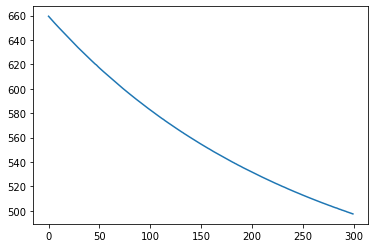

In [26]:
plt.plot(lls)
print(LRS.score(ValidationX, Validationy), LRS.score(ValidationX, Validationy), )

In [27]:
def heatMap(classier, testX, testy):
    res = np.zeros((4, 4))
    for i in range(len(testy)):
        prediction = classier.predict(testX[i])
        res[np.argmax(prediction)][np.argmax(testy[i])] += 1    
    return res

In [28]:
def Q6A(n_components, learningRate, k, printService):
    img, cnt = load_data(data_dir="./aligned/")
    folds = k_fold(img, k)
    llss = []
    testAcc = []
    accss = []
    globleBest = 0
    gobleBestWeight = np.zeros(n_components+1)
    for i in range(k):
        test, validation = folds[i], folds[(i+1)%k]
        train = defaultdict(list)
        for trainLoaderIter in range((i+2), (i+k)):
            trainLoaderIter = trainLoaderIter % k
            for key in folds[trainLoaderIter].keys():
                train[key].extend(folds[trainLoaderIter][key])
        TrainingX, ValidationX, TestX, Trainingy, Validationy, Testy = trainingLoaderSoftmax(train, test, validation, ['Pickup', 'Sedan', 'Minivan', 'Convertible'] )
        TrainingX, mean_image, top_sqrt_eigen_values, top_eigen_vectors = PCA(TrainingX, n_components)
        ValidationX = PCA_test(ValidationX, mean_image, top_sqrt_eigen_values, top_eigen_vectors)
        TestX = PCA_test(TestX, mean_image, top_sqrt_eigen_values, top_eigen_vectors)
        TrainingX, ValidationX, TestX = addBias(TrainingX, ValidationX, TestX)
        
        
        
        #print(TrainingX.shape)
        LRSM = Logistic_regression_softMax((TrainingX.shape[1], 4), learningRate)
        lls = []
        accs = []
        
        for _ in range(300):
            LRSM.batch_fit(TrainingX, Trainingy)
            ll = LRSM.loss(TrainingX, Trainingy)
            lls.append(ll)
            acc = LRSM.score(ValidationX, Validationy)
            accs.append(acc)
            if acc > globleBest:
                globleWeight = LRSM.w
                hm = heatMap(LRSM, TestX, Testy)
                globleBest = acc
                
        # LR now have the best weight in this data set.
        # LR.w = prevWeights
        testAcc.append(LRSM.score(TestX, Testy))
        llss.append(lls)
        accss.append(accs)
        
    averageLLs = [0]*300
    averageAccs  = [0] * 300
    standardDivMean = []
    standadDiv = []
    standardDivIndex = []
    for i in range(300):
        avgll = 0
        avgacc = 0
        
        for j in range(k):
            avgll += llss[j][i]
            avgacc += accss[j][i]
        avgll /= k
        avgacc /= k
        averageLLs[i] = avgll
        averageAccs[i] = avgacc
        if i % 50 == 0:
            tmp = []
            for j in range(k):
                tmp.append(accss[j][i])
            standadDiv.append(np.std(tmp))
            standardDivMean.append(avgacc)
            standardDivIndex.append(i)
    #print(max(averageAccs))
    
        
        
    fig, axs = plt.subplots(3, 1, figsize=(4, 12), constrained_layout=True)
    axs[0].plot(list(range(len(averageLLs))),averageLLs, '-')
    axs[0].set_title("Log likelihood vs Steps (Training)")
    axs[0].set_xlabel("Steps")
    axs[0].set_ylabel("Log likelihood")
    #fig.suptitle('This is a somewhat long figure title', fontsize=16)

    axs[1].plot(list(range(len(averageAccs))),averageAccs, '-')
    axs[1].set_xlabel("Steps")
    axs[1].set_title("Acc rate vs Steps (Validation)")
    axs[1].set_ylabel("Acc rate")
    
    
    axs[2].bar(standardDivIndex, standardDivMean, yerr=standadDiv, width = 20, align='center', alpha=0.5, ecolor='black', capsize=10)
    axs[2].set_xlabel("Steps")
    axs[2].set_title("Acc rate vs Steps (Validation)")
    axs[2].set_ylabel("Acc rate")
    
    plt.show()
    
    print("The average test acc is : ", np.average(testAcc), " and the standard divation of these acc is ", np.std(testAcc))
    print("Confusion Matrix:")
    
    for i in range(len(hm)):
        hm[i] /= sum(hm[i])
    print(hm)

Car types: ['Pickup', 'Sedan', 'Minivan', 'Convertible'] 

Pickup: 150 # of images
Sedan: 150 # of images
Minivan: 148 # of images
Convertible: 149 # of images


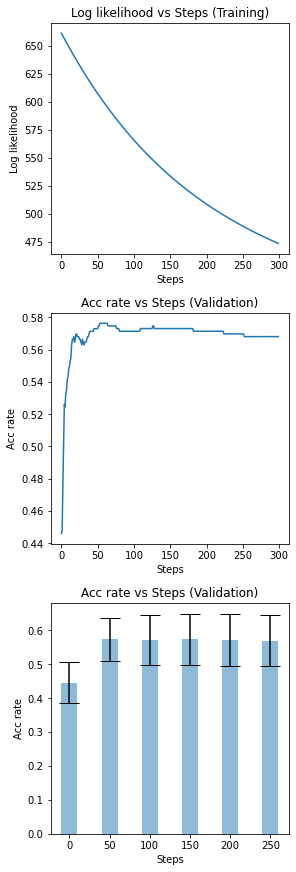

The average test acc is :  0.5680255211377363  and the standard divation of these acc is  0.07257829354089917
Confusion Matrix:
[[0.73333333 0.06666667 0.06666667 0.13333333]
 [0.         0.53846154 0.23076923 0.23076923]
 [0.125      0.1875     0.5625     0.125     ]
 [0.125      0.25       0.125      0.5       ]]


In [29]:
Q6A(40, 0.01, 10, False)

In [30]:
def Q6B(n_components, learningRate, k):
    img, cnt = load_data(data_dir="./aligned/")
    folds = k_fold(img, k)
    llssS = []
    llssB = []
    for i in range(k):
        test, validation = folds[i], folds[(i+1)%k]
        train = defaultdict(list)
        for trainLoaderIter in range((i+2), (i+k)):
            trainLoaderIter = trainLoaderIter % k
            for key in folds[trainLoaderIter].keys():
                train[key].extend(folds[trainLoaderIter][key])
        TrainingX, ValidationX, TestX, Trainingy, Validationy, Testy = trainingLoaderSoftmax(train, test, validation, ['Pickup', 'Sedan', 'Minivan', 'Convertible'] )
        TrainingX, mean_image, top_sqrt_eigen_values, top_eigen_vectors = PCA(TrainingX, n_components)
        ValidationX = PCA_test(ValidationX, mean_image, top_sqrt_eigen_values, top_eigen_vectors)
        TestX = PCA_test(TestX, mean_image, top_sqrt_eigen_values, top_eigen_vectors)
        TrainingX, ValidationX, TestX = addBias(TrainingX, ValidationX, TestX)
        
        
        
        #print(TrainingX.shape)
        LRSMS = Logistic_regression_softMax((TrainingX.shape[1], 4), learningRate)
        LRSMB = Logistic_regression_softMax((TrainingX.shape[1], 4), learningRate)
        llsS = []
        llsB = []
        
        for _ in range(300):
            LRSMS.stochastic_fit(TrainingX, Trainingy)
            LRSMB.batch_fit(TrainingX, Trainingy)
            
            llS = LRSMS.loss(TrainingX, Trainingy)
            llB = LRSMB.loss(TrainingX, Trainingy)
            #print(llS, llB, "S, B")
            
            llsS.append(llS)
            llsB.append(llB)
            
        llssS.append(llsS)
        llssB.append(llsB)
        
    averageLLsS = [0]*300
    averageLLsB  = [0] * 300
    
    for i in range(300):
        avgllS = 0
        avgllB = 0
        
        for j in range(k):
            avgllS += llssS[j][i]
            avgllB += llssB[j][i]
    
        avgllS /= k
        avgllB /= k
        
        averageLLsS[i] = avgllS
        averageLLsB[i] = avgllB
    
        
        
    fig, axs = plt.subplots(2, 1, figsize=(4, 8), constrained_layout=True)
    axs[0].plot(list(range(len(averageLLsS))),averageLLsS, '-')
    axs[0].set_title("Stochastic loss vs Steps (Training)")
    axs[0].set_xlabel("Step")
    axs[0].set_ylabel("Stochastic loss")
    #fig.suptitle('This is a somewhat long figure title', fontsize=16)

    axs[1].plot(list(range(len(averageLLsB))),averageLLsB, '-')
    axs[1].set_xlabel("Step")
    axs[1].set_title("Batch loss vs Steps (Training)")
    axs[1].set_ylabel("Batch loss")
    
    plt.show()
    
    #print("The average test acc is : ", np.average(testAcc), " and the standard divation of these acc is ", np.std(testAcc))
    

Car types: ['Pickup', 'Sedan', 'Minivan', 'Convertible'] 

Pickup: 150 # of images
Sedan: 150 # of images
Minivan: 148 # of images
Convertible: 149 # of images


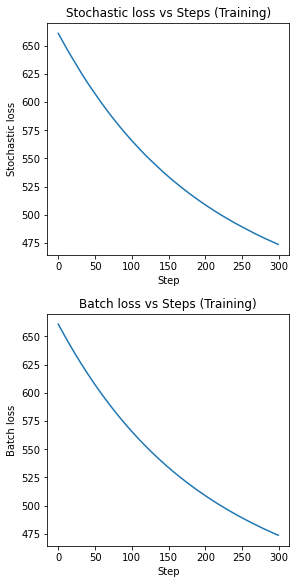

In [31]:
Q6B(40, 0.01, 10)

In [32]:
def Q6C():
    img, cnt = load_data(data_dir="./aligned/")
    folds = k_fold(img, 10)
    test, validation = folds[0], folds[1]
    train = defaultdict(list)
    for trainLoaderIter in range(2, 10):
        for key in folds[trainLoaderIter].keys():
            train[key].extend(folds[trainLoaderIter][key])
    TrainingX, ValidationX, TestX, Trainingy, Validationy, Testy = trainingLoaderSoftmax(train, test, validation, ['Pickup', 'Sedan', 'Minivan', 'Convertible'] )
    TrainingX, mean_image, top_sqrt_eigen_values, top_eigen_vectors = PCA(TrainingX, 40)
    ValidationX = PCA_test(ValidationX, mean_image, top_sqrt_eigen_values, top_eigen_vectors)
    TestX = PCA_test(TestX, mean_image, top_sqrt_eigen_values, top_eigen_vectors)
    TrainingX, ValidationX, TestX = addBias(TrainingX, ValidationX, TestX)
    #print(LRS.predict(TrainingX[300]), Trainingy[300])
    LRS = Logistic_regression_softMax((41, 4), 0.008)
    for i in range(300):
        LRS.stochastic_fit(TrainingX, Trainingy)
    weight = LRS.w.T
    fig, axs = plt.subplots(4, 1, figsize=(4, 16),constrained_layout=True)
    for i in range(len(weight)):
        tmp = weight[i][:40]
        tmp *= top_sqrt_eigen_values
        redo = np.dot(tmp, np.linalg.pinv(top_eigen_vectors)) + mean_image
        redo -= min(redo)
        redo *= 255/max(redo)
        redo = redo.reshape((200, 300))
        axs[i].imshow(redo, cmap='gray')
        
    
    

Car types: ['Pickup', 'Sedan', 'Minivan', 'Convertible'] 

Pickup: 150 # of images
Sedan: 150 # of images
Minivan: 148 # of images
Convertible: 149 # of images


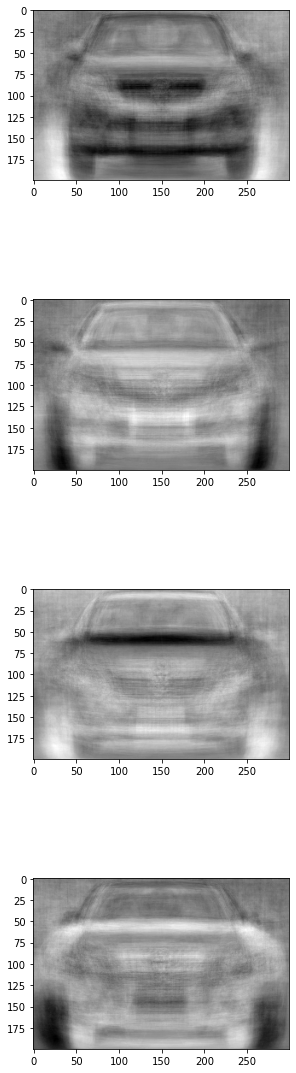

In [33]:
Q6C()